In [26]:
import sys
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau

import torch as t
from torch.utils import data
from torchvision import transforms as tsf
import scipy.misc

from pathlib import Path

from PIL import Image
import skimage
from skimage import io
import skimage.transform
import PIL
import imageio
from IPython.display import clear_output
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader


TRAIN_PATH = './train.pth'
TEST_PATH = './test.tph'
%matplotlib inline

In [2]:
def process(dataset_path, mask_path=None):
    data = []
    if mask_path:
        mask_path = Path(mask_path)

    for image in sorted(Path(dataset_path).iterdir()):
        item = {}
        img = io.imread(image)
        
        if img.shape[2] > 3:
            assert(img[:,:,3] != 255).sum()==0
        
        img = img[:,:,:3]
        item['name'] = image.name.split("_")[0]
        item['img'] = t.from_numpy(img)
        if mask_path:
            mask = io.imread(mask_path / (item['name'] + "_manual1.gif"))
            item['mask'] = t.from_numpy(mask)
        data.append(item)
    
    return data
test = process('test/images/')
t.save(test, TEST_PATH)
train_data = process('train/images', "train/1st_manual/")

/home/ubuntu/miniconda3/lib/python3.7/site-packages/imageio/plugins/_tifffile.py:8388: UserWarning: unexpected end of LZW stream (code 0)
  warnings.warn('unexpected end of LZW stream (code %i)' % code)


In [3]:
class Dataset():
    def __init__(self, data, source_transform, target_transform):
        self.datas = data
        self.s_transform = source_transform
        self.t_transform = target_transform
    def __getitem__(self, index):
        data = self.datas[index]
        img = data['img'].numpy()
        mask = data['mask'][:,:,None].byte().numpy()
        img = self.s_transform(img)
        mask = self.t_transform(mask)
        return img, mask
    def __len__(self):
        return len(self.datas)
s_trans = tsf.Compose([
    tsf.ToPILImage(),
    tsf.Resize((128, 128)),
    tsf.ToTensor(),
    tsf.Normalize(mean = [0.5, 0.5, 0.5],std = [0.5, 0.5, 0.5])
]
)
t_trans = tsf.Compose([
    tsf.ToPILImage(),
    tsf.Resize((128, 128), interpolation=PIL.Image.NEAREST),
    tsf.ToTensor()]
)
dataset = Dataset(train_data, s_trans, t_trans)

In [8]:
dataset[0][0].shape, dataset[0][1].shape

(torch.Size([3, 128, 128]), torch.Size([1, 128, 128]))

In [20]:
X_train = []
X_test = []
for i in range(0, 20):
    if i < 4:
         X_test.append(dataset[i])
    else:
         X_train.append(dataset[i])

In [17]:
class RotatedDataset():
    def __init__(self, data, angle):
        self.datas = data
        self.angle = angle
        self.s_transform = tsf.Compose([
            tsf.ToPILImage(),
            tsf.Lambda(lambda x: tsf.functional.affine(x, self.angle,
                                                       translate=(0, 0), scale=1, 
                                                       shear = False)),
            tsf.Resize((128, 128)),
            tsf.ToTensor(),
            tsf.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5]),
        ])
        self.t_transform = t_trans = tsf.Compose([
            tsf.ToPILImage(),
            tsf.Lambda(lambda x: tsf.functional.affine(x, self.angle,
                                                       translate=(0, 0), scale=1,
                                                       shear = False)),
            tsf.Resize((128, 128), interpolation=PIL.Image.NEAREST),
            tsf.ToTensor()
        ])
    def __getitem__(self, index):
        data = self.datas[index]
        img = data['img'].numpy()
        mask = data['mask'][:,:,None].byte().numpy()
        img = self.s_transform(img)
        mask = self.t_transform(mask)
        return img, mask
    def __len__(self):
        return len(self.datas)

In [21]:
for angle in range(90, 360, 90):
    rotated_dataset = RotatedDataset(train_data, angle)
    for i in range(0, 20):
        if i < 4:
             X_test.append(dataset[i])
        else:
             X_train.append(dataset[i])

In [22]:
len(X_train), len(X_test)

(64, 16)

In [38]:
train_dataloader = DataLoader(X_train, batch_size=4, shuffle=True)
test_dataloader = DataLoader(X_test, batch_size=1)

In [ ]:
def soft_dice_loss(inputs, targets):
        num = targets.size(0)
        m1  = inputs.view(num,-1)
        m2  = targets.view(num,-1)
        intersection = (m1 * m2)
        score = 2. * (intersection.sum(1) + 1) / (m1.sum(1) + m2.sum(1) + 1)
        score = 1 - score.sum()/num
        return score

In [34]:
ENCODER = "resnet18"
ENCODER_WEIGHTS = 'imagenet'

model = smp.Unet(ENCODER, encoder_weights=ENCODER_WEIGHTS, classes=1, activation=None)
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = t.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [35]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    verbose=True,
)

In [40]:
max_score = 0

for i in range(0, 10):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_dataloader)
    test_logs = valid_epoch.run(test_dataloader)
    
    # do something (save model, change lr, etc.)
    if max_score < test_logs['iou_score']:
        max_score = test_logs['iou_score']
        t.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 16/16 [00:02<00:00,  6.28it/s, dice_loss - 0.8944, iou_score - 0.00965] 
Model saved!

Epoch: 1
valid: 100%|██████████| 16/16 [00:02<00:00,  5.95it/s, dice_loss - 0.97, iou_score - 0.01388]  
Model saved!

Epoch: 2
valid: 100%|██████████| 16/16 [00:02<00:00,  6.06it/s, dice_loss - 0.3175, iou_score - 0.014]   
Model saved!

Epoch: 3
valid: 100%|██████████| 16/16 [00:02<00:00,  6.34it/s, dice_loss - -0.07404, iou_score - 0.018] 
Model saved!

Epoch: 4
valid: 100%|██████████| 16/16 [00:02<00:00,  5.91it/s, dice_loss - 2.071, iou_score - 0.02174]
Model saved!

Epoch: 5
valid: 100%|██████████| 16/16 [00:02<00:00,  6.43it/s, dice_loss - 1.337, iou_score - 0.02683]
Model saved!

Epoch: 6
valid: 100%|██████████| 16/16 [00:02<00:00,  6.66it/s, dice_loss - 1.167, iou_score - 0.03414]
Model saved!

Epoch: 7
valid: 100%|██████████| 16/16 [00:02<00:00,  5.92it/s, dice_loss - 1.046, iou_score - 0.04766]
Model saved!

Epoch: 8
valid: 100%|██████████| 16/16 [00:02<00

In [41]:
model = t.load('./best_model.pth')

In [42]:
s_trans = tsf.Compose([
    tsf.ToPILImage(),
    tsf.Resize((128, 128)),
    tsf.ToTensor(),
    tsf.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])
])
class TestDataset():
    def __init__(self,path,source_transform):
        self.datas = t.load(path)
        self.s_transform = source_transform
    def __getitem__(self, index):
        data = self.datas[index]
        img = data['img'].numpy()
        img = self.s_transform(img)
        return img
    def __len__(self):
        return len(self.datas)

testset = TestDataset(TEST_PATH, s_trans)
testdataloader = DataLoader(testset,batch_size=1)

In [43]:
os.makedirs("transf_result")

In [44]:
model = model.eval()
for ex_id, data in enumerate(testdataloader):
    data = t.autograd.Variable(data, volatile=True)
    o = model(data)
    
    source_image = io.imread("test/images/%s_test.tif" % str(ex_id + 1).zfill(2))
    tm = o[0][0].data.cpu().numpy()
    tm = skimage.transform.resize(tm, source_image.shape[:-1])
    tm = (tm > 0.5).astype(int)
    
    imageio.imwrite("transf_result/%s.png" % (ex_id + 1), tm)

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ubuntu/miniconda3/lib/python3.7/site-packages/skimage/external/tifffile/tifffile.py:2618: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to savin

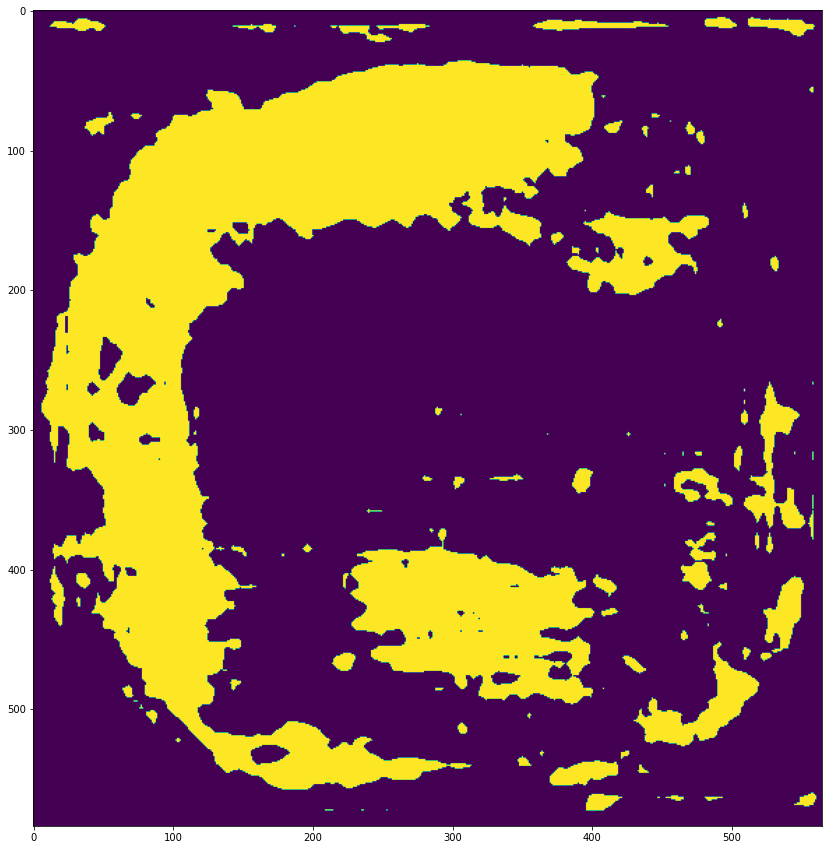

In [45]:
plt.figure(figsize=(15, 15))
plt.imshow(tm)